In [1]:
import pandas as pd
from metasense.data import load_board
from path import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
DATA_DIR = Path("/home/sharad/data/metasense/la/")

In [60]:
(X_train, Y_train), (X_test, Y_test) = load_board(4)

## Sanity Check

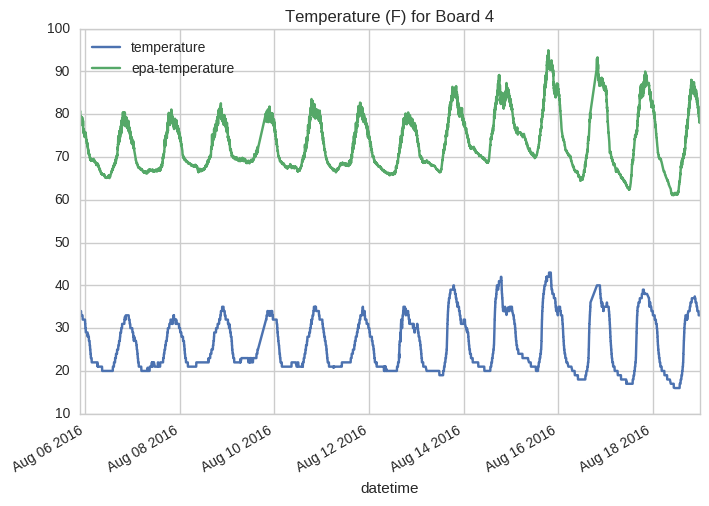

In [9]:
X_train[['temperature', 'epa-temperature']].plot()
plt.title("Temperature (F) for Board 4")
plt.show()

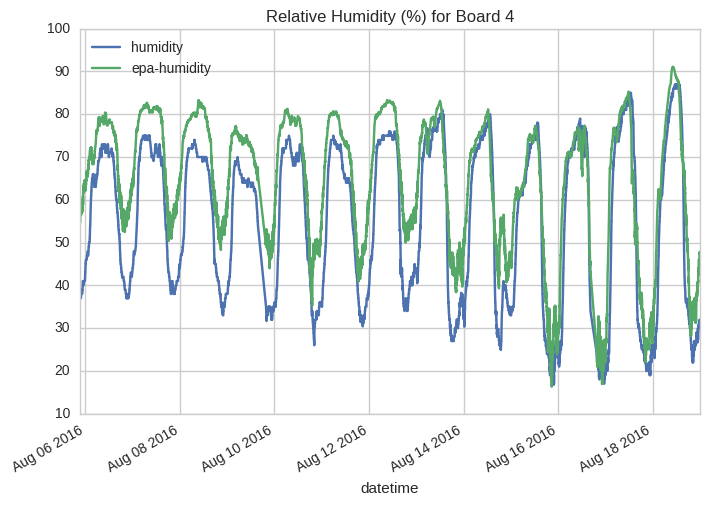

In [10]:
X_train[['humidity', 'epa-humidity']].plot()
plt.title("Relative Humidity (%) for Board 4")
plt.show()

# Training with board 4

Let's see how models perform. We'll train on the first two weeks and evaluate on the rest of the data.

In [117]:
train_data, test_data = X_train.join(Y_train), X_test.join(Y_test)
def benchmark(name, cf, features, output):
    cf.fit(train_data[features], train_data[output])
    error = (test_data[output] - cf.predict(test_data[features])) ** 2
    print("%s: %f" % (name, np.sqrt(error.mean())))
    return (name, error, cf, features)

BENCHMARKS = [
    ("Linear[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', LinearRegression())])),
    ("Linear[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', LinearRegression())])),
    #("Linear[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', LinearRegression())])),
    ("Ridge[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Ridge(1))])),
    ("Ridge[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Ridge(1))])),
    #("Ridge[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', Ridge(10))])),
    ("Lasso[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Lasso(10))])),
    ("Lasso[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso(10))])),
    #("Lasso[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', Lasso(10))])),
]
CO_FEATURES = (["co", "temperature", "humidity", "pressure"], "epa-co")
O3_FEATURES = (["o3", "co", "temperature", "humidity", "pressure"], "epa-o3")
NO2_FEATURES = (["o3", "no2", "co", "temperature", "humidity", "pressure"], "epa-no2")
def benchmark_full(features, output):
    results = {}
    best = (float('inf'), None)
    for name, cf in BENCHMARKS:
        results[name] = benchmark(name, cf, features, output)
        _, error, _, _ = results[name]
        avg_error = np.sqrt(error.mean())
        if avg_error < best[0]:
            best = (avg_error, results[name])
    print_function(best[1])
    return best
def plot_prediction(pred, actual):
    plt.figure()
    test_data.loc[:'09-01-2016'][pred].plot(alpha=0.8)
    test_data.loc[:'09-01-2016'][actual].plot(alpha=0.8)
    plt.legend(loc='best')
    plt.figure()
    test_data.loc['09-01-2016':'09-15-2016'][pred].plot(alpha=0.8)
    test_data.loc['09-01-2016':'09-15-2016'][actual].plot(alpha=0.8)
    plt.legend(loc='best')
    plt.figure()
    test_data.loc['09-15-2016':'10-01-2016'][pred].plot(alpha=0.8)
    test_data.loc['09-15-2016':'10-01-2016'][actual].plot(alpha=0.8)
    plt.legend(loc='best')
    plt.figure()
    test_data.loc['10-01-2016':][pred].plot(alpha=0.8)
    test_data.loc['10-01-2016':][actual].plot(alpha=0.8)
    plt.legend(loc='best')
    plt.show()
def print_function(result):
    name, _, cf, features = result
    poly = cf.named_steps['poly']
    func = cf.named_steps['cf'].coef_
    intercept = cf.named_steps['cf'].intercept_
    print("f(x) = ", end="")
    terms = []
    for term in poly.powers_:
        polyterms = ["%s^%u" % (features[i], power) if power > 1 else "%s" % features[i] for i, power in enumerate(term) if power > 0]
        terms.append(" * ".join(polyterms))
    print(" + ".join(["%.2E * %s" % (c, t) for c, t in zip(func, terms) if c != 0.0] + [str(intercept)]))

Linear[1]: 0.128913
Linear[2]: 0.133629
Ridge[1]: 0.128913
Ridge[2]: 0.136579
Lasso[1]: 0.201290
Lasso[2]: 0.132900
f(x) = 3.23E-03 * co + -6.32E-03 * temperature + -1.72E-03 * humidity + -9.92E-03 * pressure + 10.3995054106


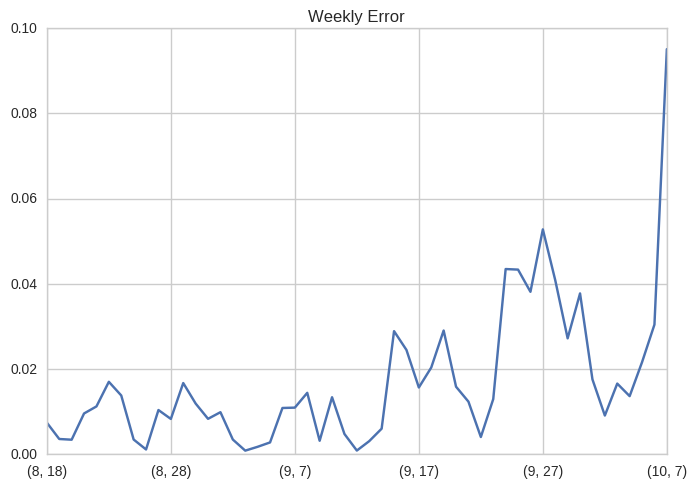

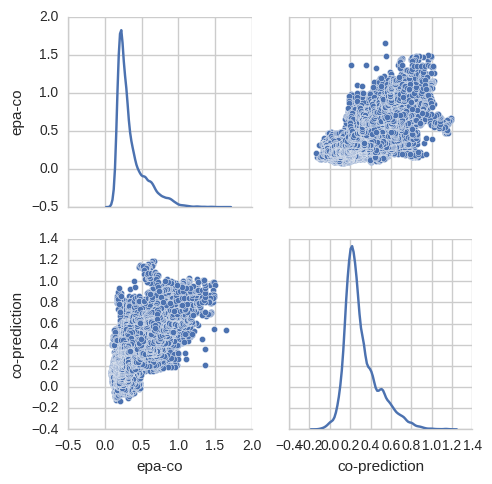

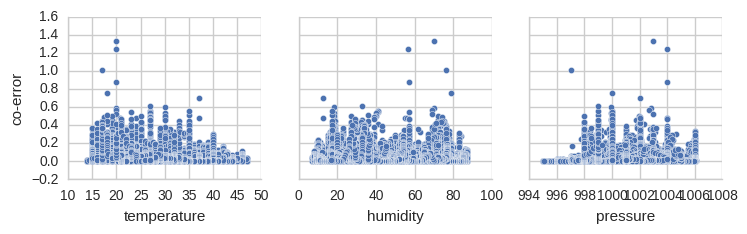

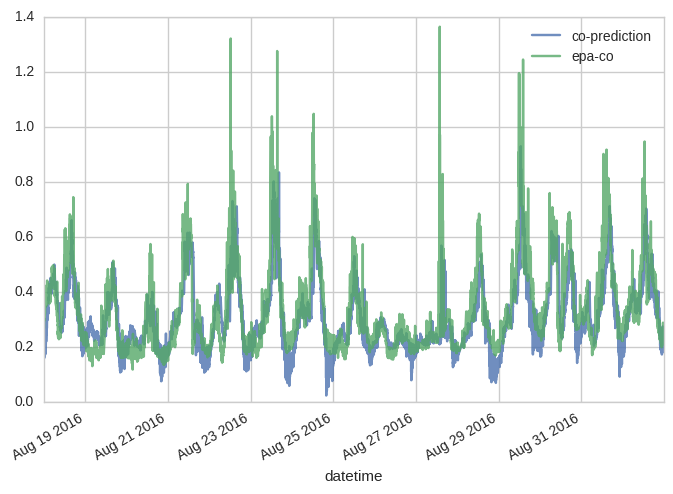

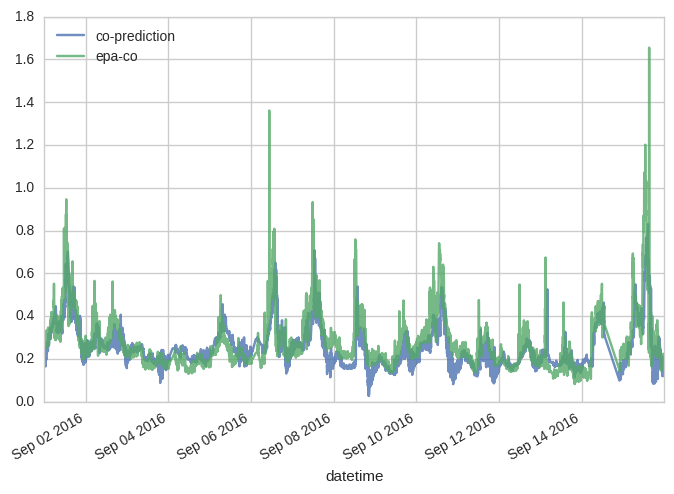

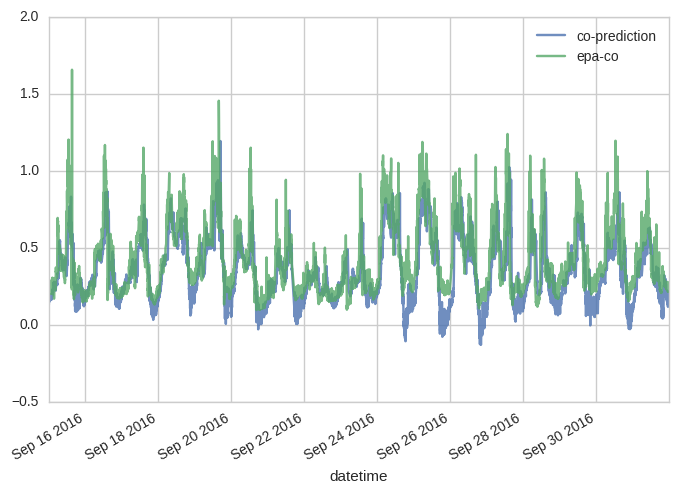

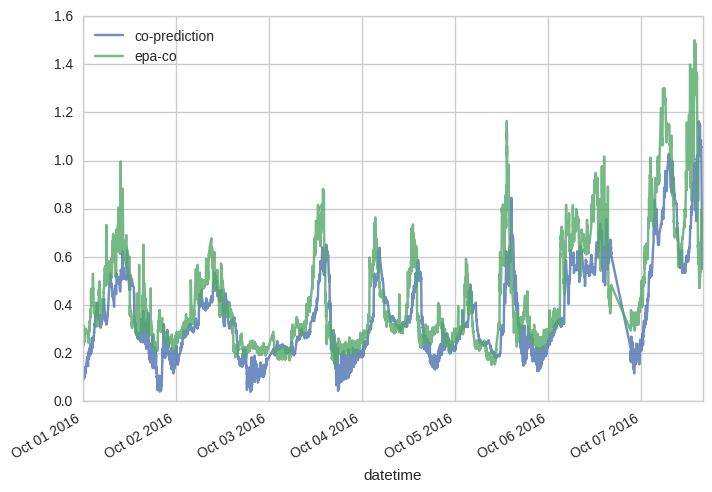

In [110]:
error, results = benchmark_full(*CO_FEATURES)
results[1].groupby(lambda x: (x.month, x.day)).mean().plot()
plt.title("Weekly Error")
test_data['co-error'] = results[1]
train_data['co-error'] = (results[2].predict(train_data[CO_FEATURES[0]]) - train_data[CO_FEATURES[1]])
test_data['co-prediction'] = results[2].predict(test_data[CO_FEATURES[0]])
train_data['co-prediction'] = results[2].predict(train_data[CO_FEATURES[0]])
sns.pairplot(test_data, vars=['epa-co','co-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['co-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('co-prediction', 'epa-co')
plt.show()

Linear[1]: 10.071693
Linear[2]: 16.955512
Ridge[1]: 10.071750
Ridge[2]: 14.340146
Lasso[1]: 13.880760
Lasso[2]: 12.694180
f(x) = 3.26E-01 * o3 + -1.40E-01 * co + 1.86E+00 * temperature + -6.37E-02 * humidity + 2.29E-01 * pressure + -273.033684486


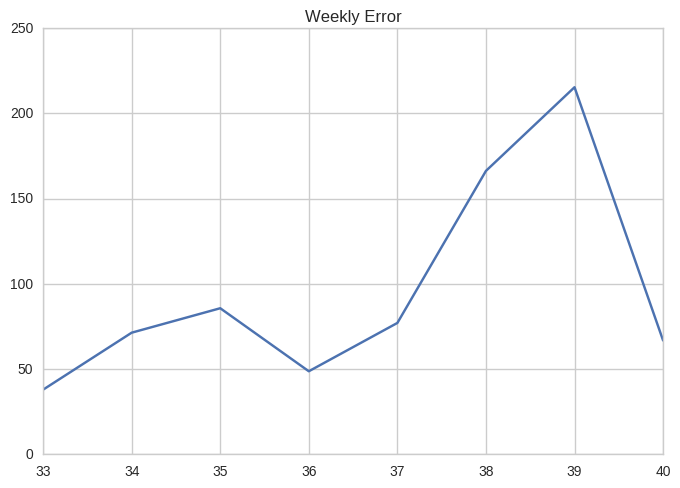

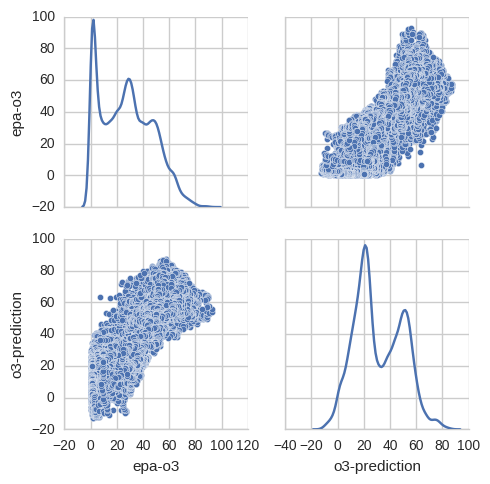

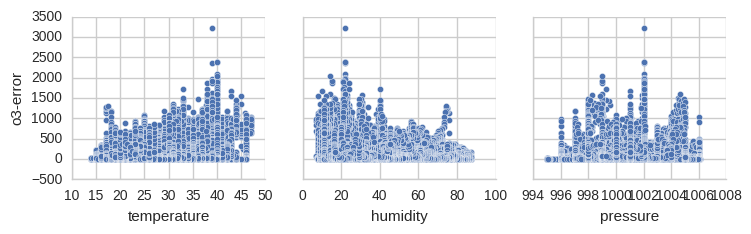

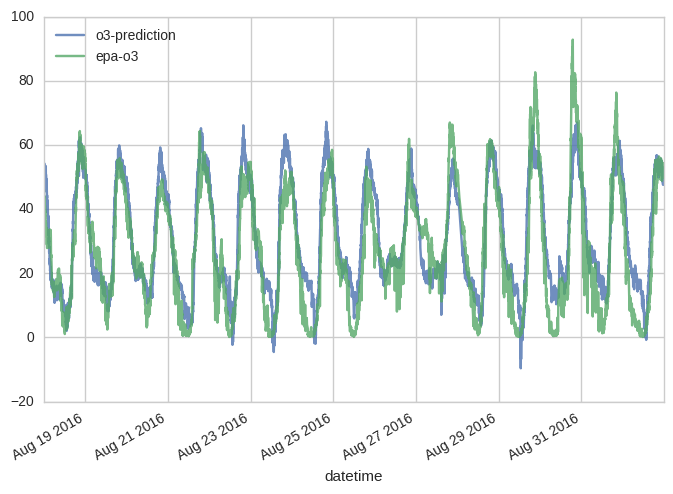

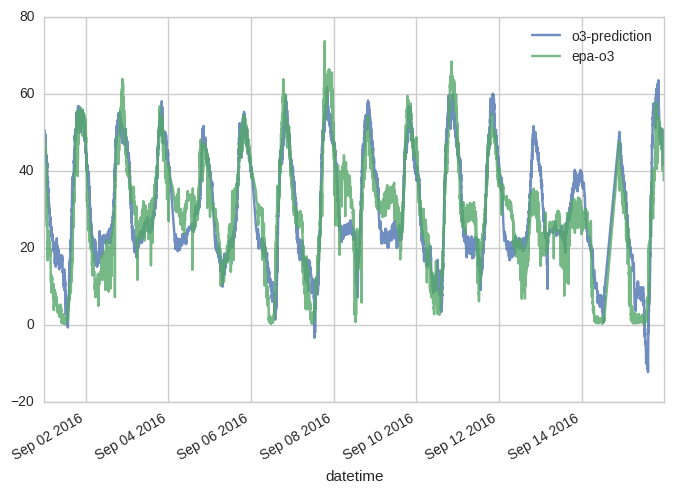

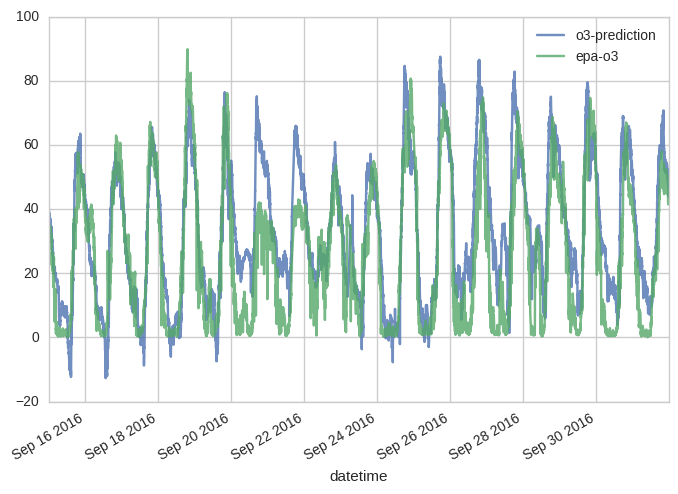

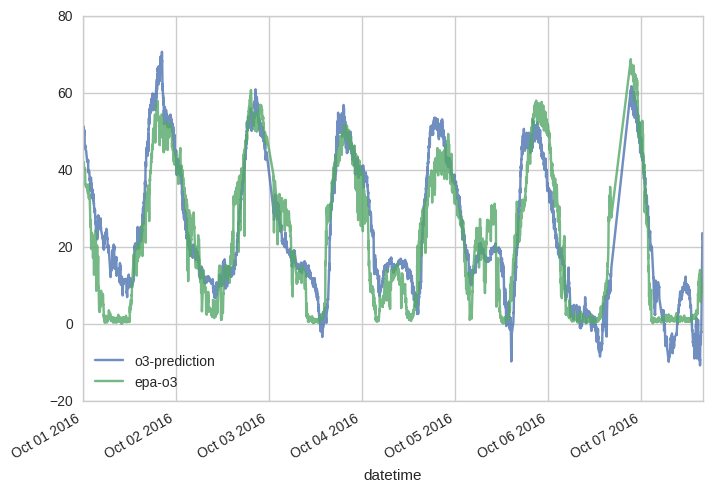

In [109]:
error, results = benchmark_full(*O3_FEATURES)
plt.figure()
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
test_data['o3-error'] = results[1]
train_data['o3-error'] = (results[2].predict(train_data[O3_FEATURES[0]]) - train_data[O3_FEATURES[1]])
test_data['o3-prediction'] = results[2].predict(test_data[O3_FEATURES[0]])
train_data['o3-prediction'] = results[2].predict(train_data[O3_FEATURES[0]])
sns.pairplot(test_data, vars=['epa-o3','o3-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['o3-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('o3-prediction', 'epa-o3')
plt.show()

# NO2 with corrections

Linear[1]: 6.719409
Linear[2]: 7.779242
Ridge[1]: 6.719401
Ridge[2]: 9.098186
Lasso[1]: 8.206317
Lasso[2]: 6.788480
f(x) = -2.61E-01 * o3 + 2.00E-01 * no2 + 1.59E-01 * co + -1.92E-01 * temperature + -4.91E-01 * humidity + 2.50E-01 * pressure + -171.876506828


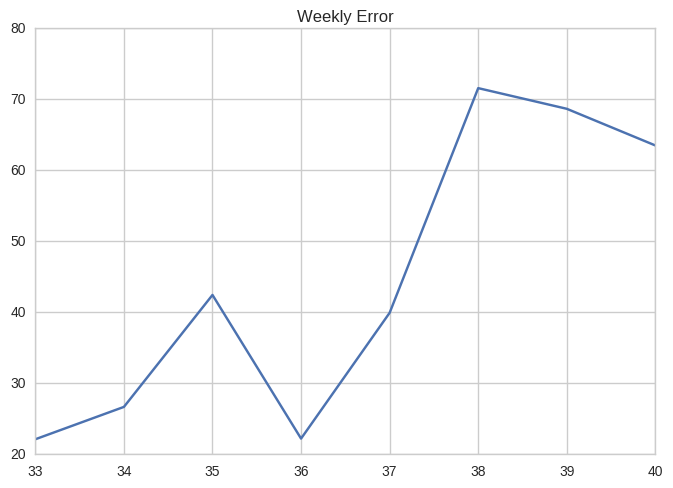

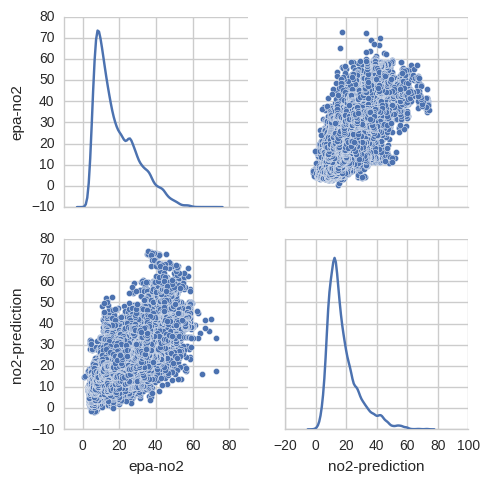

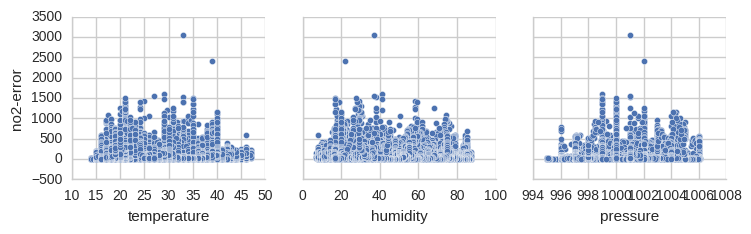

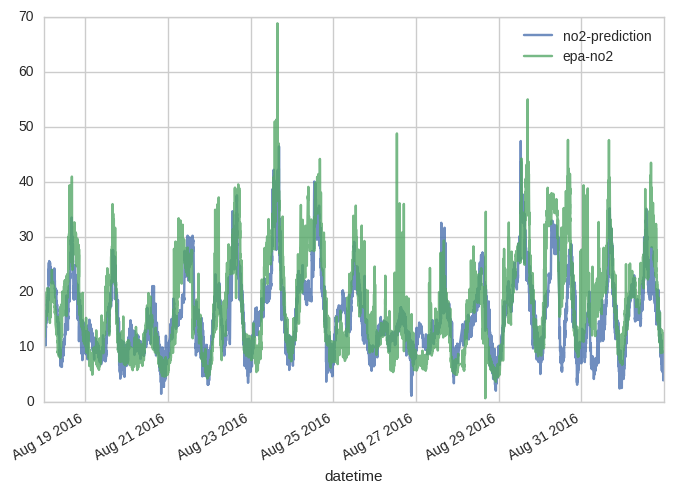

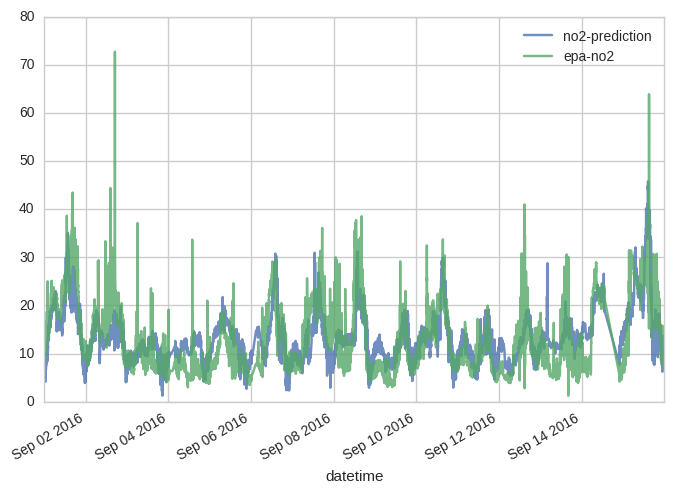

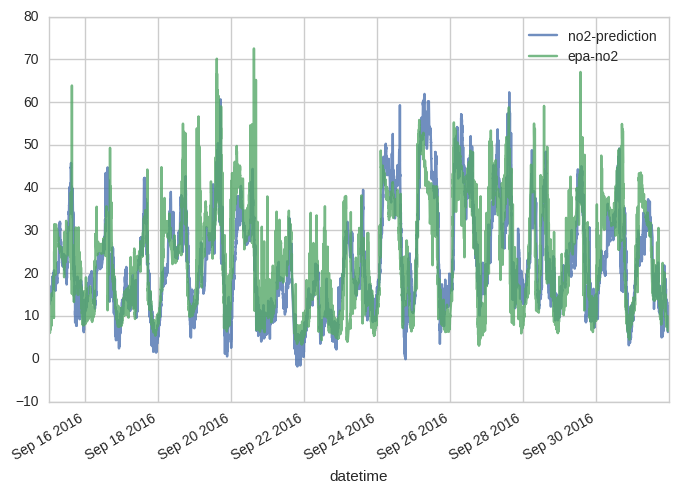

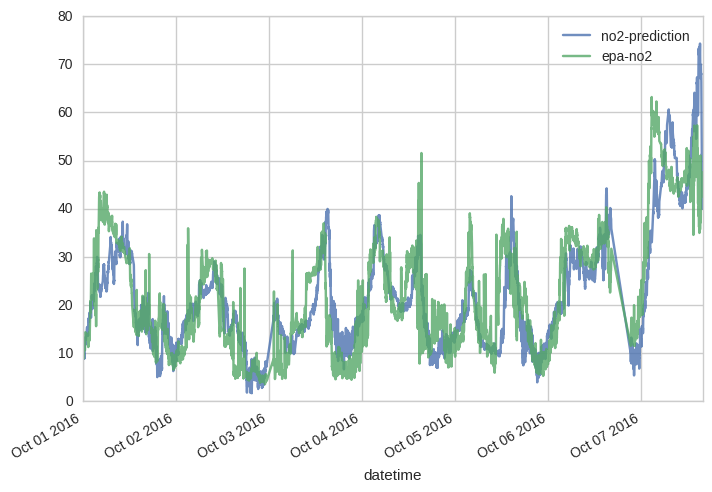

In [118]:
error, results = benchmark_full(*NO2_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
test_data['no2-error'] = results[1]
train_data['no2-error'] = (results[2].predict(train_data[NO2_FEATURES[0]]) - train_data[NO2_FEATURES[1]])
test_data['no2-prediction'] = results[2].predict(test_data[NO2_FEATURES[0]])
train_data['no2-prediction'] = results[2].predict(train_data[NO2_FEATURES[0]])
sns.pairplot(test_data, vars=['epa-no2','no2-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['no2-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('no2-prediction', 'epa-no2')
plt.show()

# NO2 without corrections

Linear[1]: 6.761908
Linear[2]: 7.395185
Ridge[1]: 6.761920
Ridge[2]: 7.365315
Lasso[1]: 8.203177
Lasso[2]: 6.563483
f(x) = 7.58E-04 * o3-u * co-u + -1.12E-02 * o3-u * humidity + 8.18E-05 * o3-u * pressure + -8.97E-04 * no2-u * co-u + 9.81E-03 * no2-u * humidity + -5.89E-05 * no2-u * pressure + -2.96E-04 * co-u^2 + 5.22E-03 * co-u * temperature + 1.06E-04 * co-u * pressure + -1.38E-03 * temperature * pressure + 1.49E-03 * humidity^2 + -2.64E-04 * humidity * pressure + 3.10E-04 * pressure^2 + -264.382022216


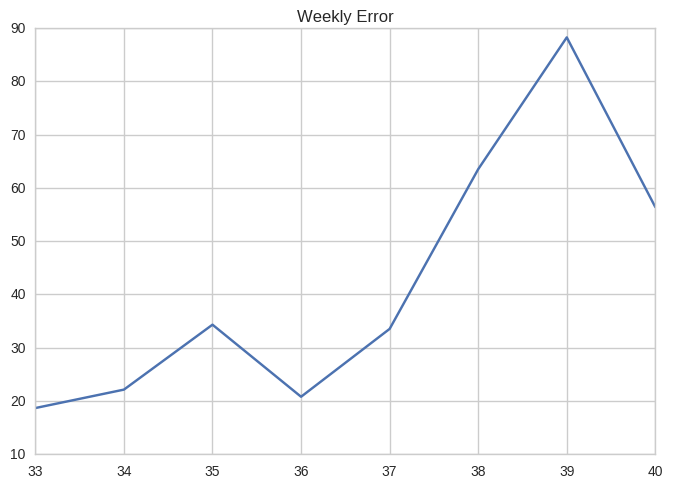

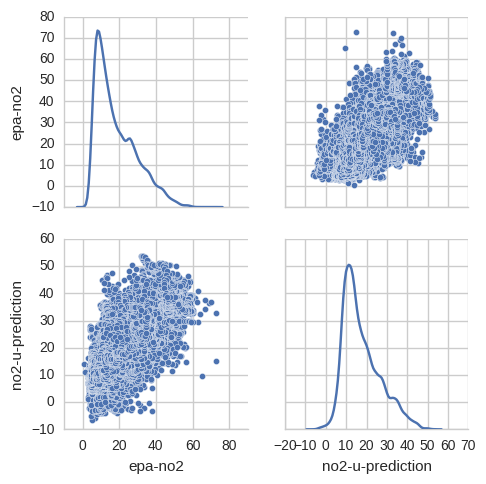

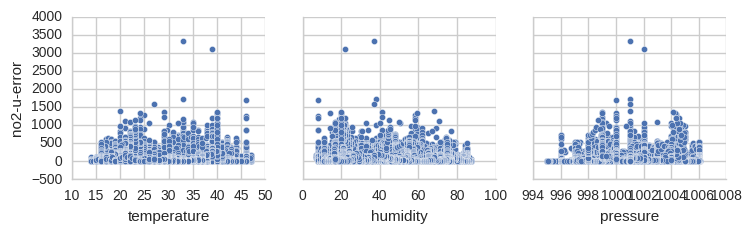

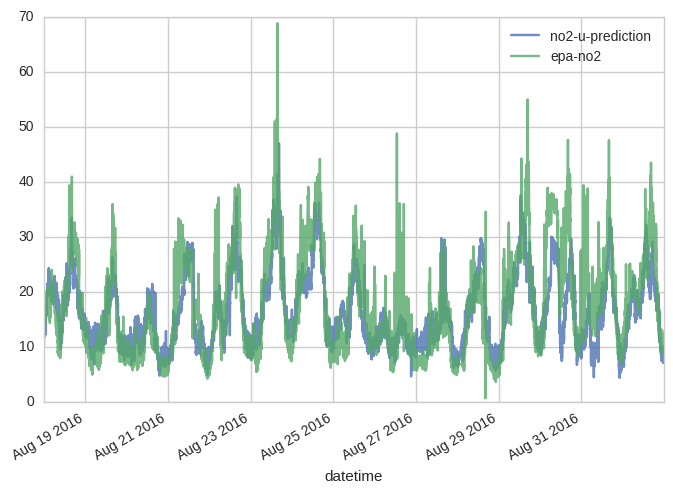

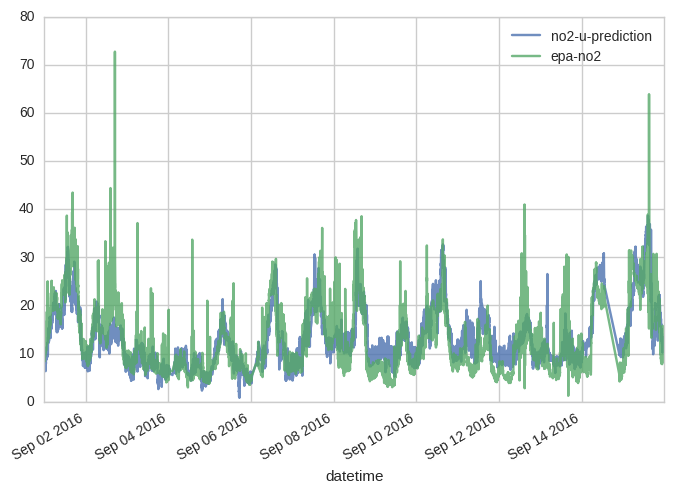

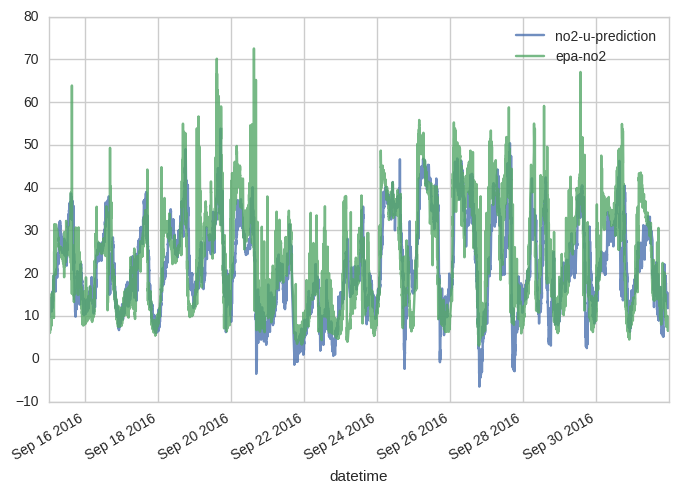

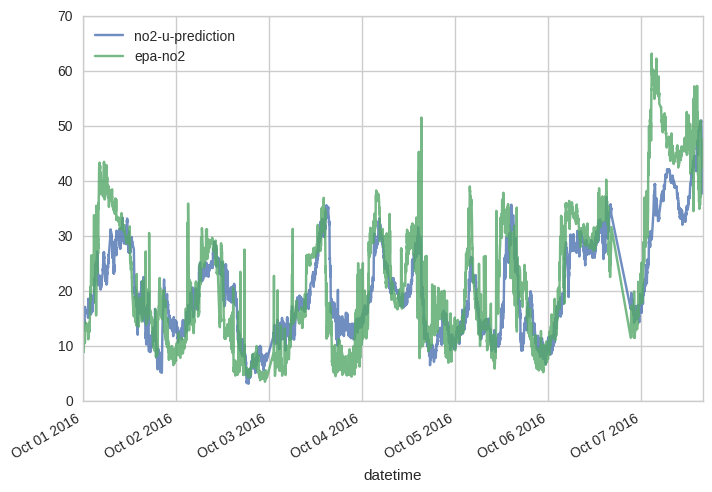

In [112]:
features = ["o3-u", "no2-u", "co-u", "temperature", "humidity", "pressure"]
error, results = benchmark_full(features, "epa-no2")
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
test_data['no2-u-error'] = results[1]
train_data['no2-u-error'] = (results[2].predict(train_data[features]) - train_data[NO2_FEATURES[1]])
test_data['no2-u-prediction'] = results[2].predict(test_data[features])
train_data['no2-u-prediction'] = results[2].predict(train_data[features])
sns.pairplot(test_data, vars=['epa-no2','no2-u-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['no2-u-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('no2-u-prediction', 'epa-no2')
plt.show()

# Making functions for other boards

In [119]:
def get_functions(name):
    data = pd.read_csv(DATA_DIR / "csv" / name, index_col='datetime', parse_dates=True)
    co_classifier = Pipeline([('poly', PolynomialFeatures(3)), ('cf', Lasso())])
    co_classifier.fit(data[CO_FEATURES[0]], data[CO_FEATURES[1]])
    print("CO")
    print("===========")
    print_function((None, None, co_classifier, CO_FEATURES[0]))
    print()
    
    o3_classifier = Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])
    o3_classifier.fit(data[O3_FEATURES[0]], data[O3_FEATURES[1]])
    print("O3")
    print("===========")
    print_function((None, None, o3_classifier, O3_FEATURES[0]))
    print()
    
    no2_classifier = Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])
    no2_classifier.fit(data[NO2_FEATURES[0]], data[NO2_FEATURES[1]])
    print("NO2")
    print("===========")
    print_function((None, None, no2_classifier, NO2_FEATURES[0]))
    print()

In [120]:
get_functions("B2.csv")

FileNotFoundError: File b'/home/sharad/data/metasense/la/csv/B2.csv' does not exist

In [225]:
get_functions("B5.csv")

CO
f(x) = 4.76E-07 * co-A * co-W + 1.13E-09 * co-W^2 + -2.81E-07 * co-A^3 + -7.94E-09 * co-A^2 * co-W + 5.15E-07 * co-A^2 * temperature + 2.23E-08 * co-A^2 * humidity + -1.15E-11 * co-A * co-W^2 + 6.97E-09 * co-A * co-W * temperature + -1.89E-09 * co-A * co-W * humidity + 4.33E-07 * co-A * temperature * humidity + 2.32E-07 * co-A * humidity^2 + 2.04E-13 * co-W^3 + -1.89E-12 * co-W^2 * temperature + -6.33E-12 * co-W^2 * humidity + 2.03E-09 * co-W * temperature^2 + -1.18E-09 * co-W * temperature * humidity + -5.98E-10 * co-W * humidity^2 + -1.83E-07 * humidity^3

O3
f(x) = -2.60E-03 * co-W + 8.60E-04 * o3-A^2 + -1.72E-04 * o3-A * o3-W + 3.59E-05 * o3-A * co-A + -5.71E-08 * o3-A * co-W + -6.90E-05 * o3-W^2 + 5.42E-05 * o3-W * co-A + -4.17E-07 * o3-W * co-W + -8.62E-05 * o3-W * humidity + -2.44E-05 * co-A^2 + 3.69E-07 * co-A * co-W + 7.00E-09 * co-W^2 + -9.25E-09 * co-W * temperature + -3.01E-07 * co-W * humidity

NO2
f(x) = -7.10E-04 * co-W + 1.79E-04 * o3-A * o3-W + 6.18E-06 * o3-A * no2

In [226]:
get_functions("B8.csv")

CO
f(x) = -4.42E-07 * co-A^2 + -4.37E-07 * co-A * co-W + 1.90E-06 * co-A * temperature + -1.51E-07 * co-W^2 + -9.61E-07 * co-W * temperature + 1.27E-05 * co-W * humidity + -1.51E-11 * co-A^3 + 1.15E-10 * co-A^2 * co-W + -2.86E-10 * co-A^2 * temperature + 2.87E-09 * co-A^2 * humidity + 2.03E-10 * co-A * co-W^2 + -4.81E-09 * co-A * co-W * temperature + 9.84E-09 * co-A * co-W * humidity + 2.08E-08 * co-A * temperature^2 + -3.88E-08 * co-A * temperature * humidity + -1.47E-07 * co-A * humidity^2 + 2.47E-10 * co-W^3 + -4.54E-09 * co-W^2 * temperature + -1.14E-08 * co-W^2 * humidity + 2.53E-08 * co-W * temperature^2 + 1.24E-07 * co-W * temperature * humidity + 5.66E-08 * co-W * humidity^2 + -4.02E-08 * temperature^3 + -1.52E-07 * temperature^2 * humidity + -1.05E-07 * temperature * humidity^2 + 7.34E-07 * humidity^3

O3
f(x) = -3.21E-03 * o3-A^2 + 2.85E-03 * o3-A * o3-W + 6.97E-04 * o3-A * co-A + 1.60E-04 * o3-A * co-W + 5.83E-04 * o3-A * temperature + -1.95E-03 * o3-A * humidity + -1.97E-04

In [227]:
get_functions("B9.csv")

CO
f(x) = 9.37E-06 * co-A^2 + 6.09E-06 * co-A * co-W + -1.96E-04 * co-A * temperature + 5.38E-05 * co-A * humidity + -1.27E-07 * co-W^2 + 1.00E-05 * co-W * humidity + -3.01E-05 * humidity^2 + -1.35E-09 * co-A^3 + -4.40E-09 * co-A^2 * co-W + -7.11E-08 * co-A^2 * temperature + -6.14E-08 * co-A^2 * humidity + -9.04E-11 * co-A * co-W^2 + -1.29E-07 * co-A * co-W * temperature + -5.19E-08 * co-A * co-W * humidity + 4.20E-06 * co-A * temperature^2 + -1.28E-06 * co-A * temperature * humidity + 1.09E-07 * co-A * humidity^2 + -2.63E-11 * co-W^3 + 5.45E-10 * co-W^2 * temperature + 2.89E-08 * co-W^2 * humidity + -5.38E-07 * co-W * temperature^2 + 1.89E-06 * co-W * temperature * humidity + -8.66E-07 * co-W * humidity^2 + 4.04E-07 * temperature^3 + -2.10E-05 * temperature^2 * humidity + 3.82E-06 * temperature * humidity^2 + 5.37E-07 * humidity^3

O3
f(x) = -6.03E-02 * o3-A + -5.17E-01 * co-A + -1.04E-01 * co-W + -8.70E-01 * humidity + 2.08E-05 * o3-A^2 + 2.85E-05 * o3-A * o3-W + -3.38E-03 * o3-A * c

In [228]:
get_functions("B10.csv")

CO
f(x) = 1.73E-06 * co-A^2 + 2.75E-07 * co-A * co-W + -1.51E-06 * co-A * humidity + 2.91E-07 * co-W^2 + 3.64E-05 * co-W * humidity + -3.29E-05 * humidity^2 + -3.80E-10 * co-A^3 + -2.12E-11 * co-A^2 * co-W + 1.44E-09 * co-A^2 * temperature + 4.96E-09 * co-A^2 * humidity + -1.52E-10 * co-A * co-W^2 + -1.90E-08 * co-A * co-W * temperature + 1.17E-08 * co-A * co-W * humidity + 7.21E-08 * co-A * temperature^2 + 4.84E-07 * co-A * temperature * humidity + -3.03E-07 * co-A * humidity^2 + 3.38E-10 * co-W^3 + -4.25E-08 * co-W^2 * temperature + -2.91E-08 * co-W^2 * humidity + -1.80E-06 * co-W * temperature^2 + 4.08E-06 * co-W * temperature * humidity + -6.07E-07 * co-W * humidity^2 + 9.22E-06 * temperature^3 + -1.14E-05 * temperature^2 * humidity + -2.03E-05 * temperature * humidity^2 + 5.32E-06 * humidity^3

O3
f(x) = -2.88E-02 * co-W + -8.53E-04 * o3-A^2 + 3.92E-04 * o3-A * o3-W + -3.23E-04 * o3-A * co-A + -1.39E-05 * o3-A * co-W + 1.31E-02 * o3-A * temperature + -1.66E-03 * o3-A * humidity + 